## Kernel limit for a Random Fourier Feature model

The formula for the deterministic equivalent $R_{n,p}$ can be applied for every value of $p$. However, when $p \to \infty$, the random feature model reduces to a standard kernel machine where:
$$
K(x,x') = \mathbb{E}_{w \in \mu(w)}[\varphi(x, w) \varphi(x', w)]
$$
As shown in [Rahimi and Recht](https://people.eecs.berkeley.edu/~brecht/papers/07.rah.rec.nips.pdf), if we let $\phi(\vec x, \vec w) = \cos(\langle \vec w,\vec x \rangle + \vec b)$ and $\vec w \in \mathcal{N}(0, \gamma\mathbf{1}_d)$, then the liming kernel is the usual RBF kernel $K(x,x') =\exp(-\gamma\frac{||x-x'||^2}{2})$.

In this notebook, we aim at verifying whether the predictions for the deterministic equivalent in the kernel limit $p \to \infty$ (Corollary 3.4) are in agreement with the risk induced by a RBF kernel ridge regression problem. In particular, we will proceed as shown in Appendix C.3 Empirical Diagonalization:
1) We sample $N$ points $\vec x \in \mathbb{R}^d$ from $\mathcal{N}(0, \mathbf{1}_d)$
2) We sample $P$ points $\vec w \in \mathbb{R}^p$ from $\mathcal{N}(0, \gamma \mathbf{1}_d)$
3) We can now approximate the PDF over $\vec w$ and write $K(x,x') \approx \sum_j^P \varphi(\vec x,\vec w_j) \varphi(\vec x',\vec w_j)$ where $\varphi(\vec x, \vec w) = \frac{1}{\sqrt{p}}\cos(\langle \vec x, \vec w \rangle)$
4) Starting from the $N$ points $\vec x_i$, we'll build the $N\times N$ matrix $\tilde K$ where $\tilde K_{ij} = \frac{1}{N} K(\vec x_i, \vec x_j)$
5) The eigenvalues $\tilde \xi_k^2$ approximate the true eigenvalues $\xi_k^2$ of $\Sigma$ for large enough $N$
6) We obtain the decomposition of $f_\star(\vec x)$ with $\beta_{\star,k} \approx \tilde \beta_k = \frac{1}{N} \vec y^T \tilde \psi_k$
7) Now we have an approximation for $\Sigma$ and $\vec\beta$. We can put those quantities inside the kernel limit of $R_{n,p}$ and obtain the theoretical risk.
8) With the ScikitLearn API, we can empirically run a RBF KRR learning task on the same training set and see whether the risks are in agreement

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use('science')

In [ ]:
# Perform the empirical diagonalization of the kernel matrix
def empiricalDiagonalization(target_function, gamma = 0.5, d = 100, N = 10000, P = 10000):
    # N large is needed to well approximate the eigenvalues
    # P large is needed here because we want to be in the kernel regime (I believe)
    X = np.random.randn(N, d)
    W = np.random.randn(d, P) * np.sqrt(2 * gamma)
    b = np.random.rand(1, P) * 2 * np.pi

    Projection = X @ W 
    Phi = np.sqrt(2.0 / P) * np.cos(Projection + b)
    Ka = Phi @ Phi.T 

    vals, vecs = np.linalg.eigh(Ka)
    vals = vals / N # Normalization; still WIP. Why is it needed? 
    vals = vals[::-1]
    vecs = vecs[:, ::-1]

    y = target_function(X) 
    betas = (1 / np.sqrt(N)) * (vecs.T @ y)
    return np.array(vals), betas

# Solver for nu_K in the kernel limit
def solveNu1KernelLimit(n, lambd, Sigma, tolerance=1e-10, maxIter=1000):
    nu = lambd 
    
    for it in range(maxIter):
        df = np.sum(Sigma / (Sigma + nu))
        nu_new = lambd + (nu / n) * df
        
        if np.abs(nu_new - nu) < tolerance:
            return nu_new
        nu = nu_new
        
    return nu

# Compute the deterministic equivalent of the variance and bias (same as in previous notebook, but specialized for kernel limit)
def computeDeterministicEquivalent(n : int, lambd : float, noise : float, Sigma : np.array, beta : np.array):
    nu1 = solveNu1KernelLimit(n, lambd, Sigma)

    BiasNum = nu1**2 * np.sum(beta**2 / (Sigma + nu1)**2 )
    BiasDen = 1 - (1/n) * np.sum(Sigma**2 / (Sigma+nu1)**2)
    Bias = BiasNum / BiasDen

    VarNum =noise**2 * np.sum(Sigma**2 / (Sigma+nu1)**2)
    VarDen = n - np.sum(Sigma**2 / (Sigma+nu1)**2)
    Var = VarNum/VarDen

    return Var, Bias

Now we'll fix a target function and compute the approximated eigenvalues matrix $\Sigma$ and decomposition $\vec \beta$

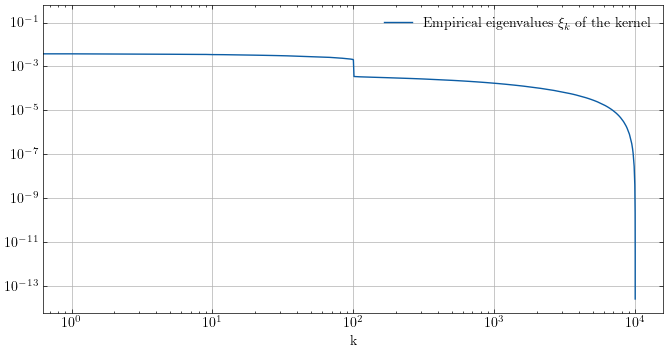

In [54]:
def target_function(X):
    rng = np.random.RandomState(42) 
    d = X.shape[1]
    w_true = rng.randn(d)
    w_true /= np.linalg.norm(w_true)
    
    proj = X @ w_true
    return np.sin(proj)
# Fix gamma 
gamma = 0.01
# Approximate eigenvalues xi_k and beta decomposition with the empirical diagonalization procedure
Sigma, beta = empiricalDiagonalization(target_function=target_function, gamma = gamma, d = 100)
# Plot those eigenvalues
plt.figure(figsize=(8,4))
plt.loglog(Sigma, label=r'Empirical eigenvalues $\xi_k$ of the kernel')
plt.xlabel('k')
plt.legend()
plt.grid()
plt.show()

Note that the spectrum for this limiting feature map is not a power law. However, now that we have $\Sigma, \vec \beta$, we can compute the deterministic equivalent for a learning problem where $N = 600$, for example:

In [55]:
# Parameters
NSamples = 600
d = 100
lambd = 1e-3
noise = 0.1

# Extract the training set and labels
X = np.random.randn(NSamples, d)
y = target_function(X) + noise * np.random.randn(NSamples)

Var, Bias = computeDeterministicEquivalent(NSamples, lambd, noise, Sigma, beta)
print(f"Deterministic Equivalent - Variance: {Var:.6f}, Bias: {Bias:.6f}, Total: {Var + Bias:.6f}")

Deterministic Equivalent - Variance: 0.000899, Bias: 0.143064, Total: 0.143963


Now given the same Kernel Ridge regression problem, let's compute the empirical risk using SciKitLearn KRR API:

In [56]:
from sklearn.kernel_ridge import KernelRidge

# Build and train the KRR model
krr = KernelRidge(kernel='rbf', alpha=NSamples*lambd, gamma=gamma)
krr.fit(X, y)
# To approximate the true risk, we can use a large test set and approximate via Monte Carlo
Ntest = 10000
X_test = np.random.randn(Ntest, d)
y_test = target_function(X_test)
y_pred = krr.predict(X_test)    
risk = np.mean((y_test - y_pred)**2)

#test_risk = get_risk_sklearn(krr, X_test, y_test)
print(f"Empirical risk for the KRR model: {risk:.6f}")

Empirical risk for the KRR model: 0.146303


The results seems to be nicely in agreement, suggesting the validity of the kernel limit for $R_{n,p}$. Let's try and evalute the whole learning curve:

In [59]:
NValues = np.arange(50, 4001, 100)
EmpiricalRisks = []
DeterministicRisks = []

for N in NValues:
    NSamples = N

    X = np.random.randn(NSamples, d)
    y = target_function(X) + noise * np.random.randn(NSamples)
    
    Var, Bias = computeDeterministicEquivalent(NSamples, lambd, noise, Sigma, beta)
    DeterministicRisks.append(Var + Bias)

    krr = KernelRidge(kernel='rbf', alpha=NSamples*lambd, gamma=gamma)
    krr.fit(X, y)
    
    X_test = np.random.randn(10000, d)   #Test set of 10000 samples
    y_test = target_function(X_test)
    y_pred = krr.predict(X_test)    
    
    risk = np.mean((y_test - y_pred)**2)
    EmpiricalRisks.append(risk)

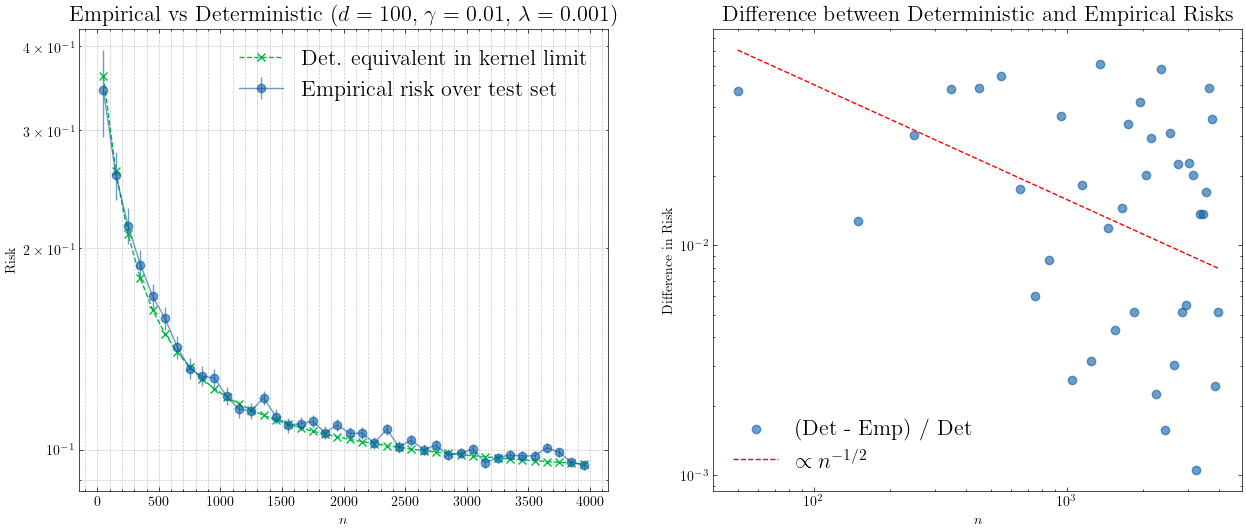

In [60]:
# Plotting the results
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.errorbar(NValues, EmpiricalRisks, yerr=1/np.sqrt(NValues)*np.array(DeterministicRisks), label='Empirical risk over test set', marker='o', alpha=0.6)
plt.plot(NValues, DeterministicRisks, label='Det. equivalent in kernel limit', marker='x', linestyle='--')
plt.xlabel('$n$')
plt.ylabel('Risk')
plt.title(f'Empirical vs Deterministic ($d={d}$, $\gamma={gamma}$, $\lambda={lambd}$)', fontsize=16)
plt.legend(fontsize=16)
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.yscale('log') # La scala logaritmica aiuta a vedere meglio la discesa
plt.subplot(1,2,2)
plt.scatter(NValues, np.abs(np.array(DeterministicRisks) - np.array(EmpiricalRisks)) / np.array(DeterministicRisks), label='(Det - Emp) / Det', marker='o', alpha=0.6)
#Reference line for N^{-1/2}
plt.plot(NValues, 0.5 * NValues**(-0.5), label=r'$\propto n^{-1/2}$', color='red', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$n$')
plt.ylabel('Difference in Risk')
plt.title('Difference between Deterministic and Empirical Risks', fontsize=16)
plt.legend(fontsize=16)
plt.savefig('kernelLimit.pdf')
plt.show()

Let's try again with a different target function $y_i = \tanh(\langle \beta, x_i\rangle) + \epsilon_i$ and now with $d = 50$, just to change things a bit

In [46]:
def target_function2(X):
    rng = np.random.RandomState(42) 
    
    d = X.shape[1]
    w_true = rng.randn(d) 
    w_true /= np.linalg.norm(w_true) # Beta unitario
    
    proj = X @ w_true
    return np.tanh(proj)

NValues = np.arange(50, 4001, 100)
EmpiricalRisks = []
DeterministicRisks = []

noise = 0.5
lambd = 1e-3
gamma = 0.05
d = 50

Sigma, beta = empiricalDiagonalization(target_function=target_function2, gamma = gamma, d = d)

for N in NValues:
    NSamples = N

    X = np.random.randn(NSamples, d)
    y = target_function2(X) + noise * np.random.randn(NSamples)
    
    Var, Bias = computeDeterministicEquivalent(NSamples, lambd, noise, Sigma, beta)
    DeterministicRisks.append(Var + Bias)

    krr = KernelRidge(kernel='rbf', alpha=NSamples*lambd, gamma=gamma)
    krr.fit(X, y)
    
    X_test = np.random.randn(10000, d)
    y_test = target_function2(X_test)
    y_pred = krr.predict(X_test)    
    
    risk = np.mean((y_test - y_pred)**2)
    EmpiricalRisks.append(risk)

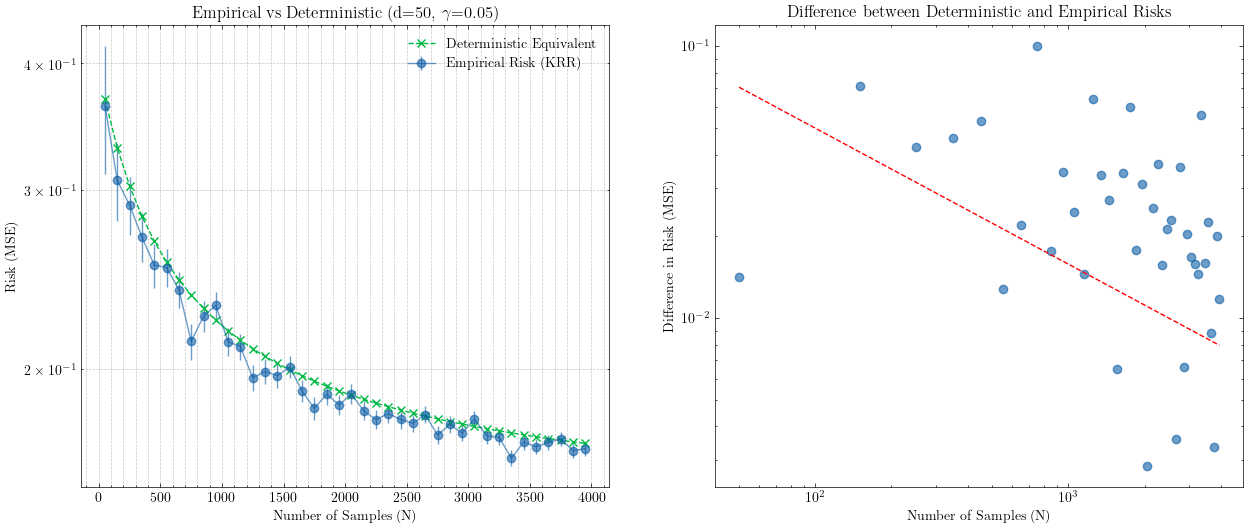

In [47]:
# Plotting the results
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.errorbar(NValues, EmpiricalRisks, yerr=1/np.sqrt(NValues)*np.array(DeterministicRisks), label='Empirical Risk (KRR)', marker='o', alpha=0.6)
plt.plot(NValues, DeterministicRisks, label='Deterministic Equivalent', marker='x', linestyle='--')
plt.xlabel('Number of Samples (N)')
plt.ylabel('Risk (MSE)')
plt.title(f'Empirical vs Deterministic (d={d}, $\gamma$={gamma})')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.yscale('log') # La scala logaritmica aiuta a vedere meglio la discesa
plt.subplot(1,2,2)
plt.scatter(NValues, np.abs(np.array(DeterministicRisks) - np.array(EmpiricalRisks)) / np.array(DeterministicRisks), label='Deterministic - Empirical', marker='o', alpha=0.6)
#Reference line for N^{-1/2}
plt.plot(NValues, 0.5 * NValues**(-0.5), label=r'Reference $N^{-1/2}$', color='red', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Samples (N)')
plt.ylabel('Difference in Risk (MSE)')
plt.title('Difference between Deterministic and Empirical Risks')
plt.show()